In [28]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, root_mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from prettytable import PrettyTable
import os
import librosa
import matplotlib.pyplot as plt
import time

We begin by loading the audio files using the os library.

In [2]:
dev_files = sorted(os.listdir('audios_development'), key=lambda x: int(x.split('.')[0]))
eval_files = sorted(os.listdir('audios_evaluation'), key=lambda x: int(x.split('.')[0]))

Next, we load the development and evaluation dataframes and concatenate them to perform preprocessing operations all at once. At the same time, we take the opportunity to correct or better reformat certain feature values.

In [3]:
df_dev = pd.read_csv("development.csv")
df_eval = pd.read_csv("evaluation.csv")
end_dev = len(df_dev)
df = pd.concat([df_dev, df_eval], sort=False)
df = df.reset_index()
df.loc[df["gender"] == "famale", "gender"] = "female"

In [4]:
df['tempo'] = df['tempo'].str.replace(r'[^\d.]', '', regex=True).astype(float)

In [5]:
for i in range(len(df)):
  df.loc[i, 'path'] = df.loc[i, 'path'].split('/')[1]

In [6]:
df.columns

Index(['index', 'Id', 'sampling_rate', 'age', 'gender', 'ethnicity',
       'mean_pitch', 'max_pitch', 'min_pitch', 'jitter', 'shimmer', 'energy',
       'zcr_mean', 'spectral_centroid_mean', 'tempo', 'hnr', 'num_words',
       'num_characters', 'num_pauses', 'silence_duration', 'path'],
      dtype='object')

In [7]:
print(df.dtypes)

index                       int64
Id                          int64
sampling_rate               int64
age                       float64
gender                     object
ethnicity                  object
mean_pitch                float64
max_pitch                 float64
min_pitch                 float64
jitter                    float64
shimmer                   float64
energy                    float64
zcr_mean                  float64
spectral_centroid_mean    float64
tempo                     float64
hnr                       float64
num_words                   int64
num_characters              int64
num_pauses                  int64
silence_duration          float64
path                       object
dtype: object


In the cells above, we can observe the feature names as they are already presented in the concatenated development and evaluation dataframes. However, there are still categorical features that need to be transformed into numerical ones to be properly used by the regressor we choose. These features are specifically 'gender' and 'ethnicity'.

Therefore, in the following cell, we apply one-hot encoding using the get_dummies function from the Pandas library on the 'gender' and 'ethnicity' features. This transformation converts the features from categorical to numerical.

We also remove the 'Id' feature because, for the purpose of regression, being a unique identifier for individual records, it does not provide any useful information for age prediction.

In [8]:
df_dropped = df.drop(columns=["Id"])
df_dropped = pd.get_dummies(df_dropped, columns=["gender", "ethnicity"])

Let us now attempt to train a regressor on the training dataset to understand the results we can achieve with the given initial features. It is important to note that from the single dataframe containing both the development and evaluation dataframes, we can extract the original development and evaluation portions. Specifically, we create a 'train_valid_mask' mask to separate the records where the 'age' feature has non-null values (corresponding to the training set records) from those where 'age' has NaN values (belonging to the test set).

We then perform a hold-out operation using the train_test_split function, which allows us to split the training dataset into two subsets (X_train, X_test) of different sizes along with their respective labels (y_train, y_test). This enables us to compute preliminary evaluation metrics.

As for the regressor, we currently choose to use a default Random Forest Regressor.

In [9]:
train_valid_mask = ~df["age"].isna()
df_dropped_example = df_dropped.drop(columns=['path'])
feature_names = df_dropped_example[train_valid_mask].drop(columns="age").columns

X = df_dropped_example.drop(columns="age").values
y = df_dropped_example["age"].values

X_dev = X[train_valid_mask]
y_dev = y[train_valid_mask]
X_eval = X[~train_valid_mask]
y_eval = y[~train_valid_mask]

X_train, X_test, y_train, y_test = train_test_split(X_dev, y_dev, shuffle=True, random_state=42)
rf = RandomForestRegressor()
y_pred = rf.fit(X_train, y_train)
print(f'r2 -> {r2_score(y_test, rf.predict(X_test))}')
print(f'mae -> {mean_absolute_error(y_test, rf.predict(X_test))}')

r2 -> 0.390238495975854
mae -> 6.698222070844687


The calculated metrics are R² and Mean Absolute Error. While the results are not highly satisfactory, there is certainly room for improvement.

In the cells below, we will analyze which regressor could be more effective in the future. Since the regressor will likely not be linear with the available data, we have decided to test three distinct regressor models: MLPRegressor, SVR, and Random Forest Regressor.

In [10]:
def evaluate_model(model):
    model.fit(X_train, y_train)
    y_hat = model.predict(X_test)
    return np.sqrt(mean_squared_error(y_test, y_hat)), r2_score(y_test, y_hat)

In [11]:
models = [
    MLPRegressor(),
    SVR(),
    RandomForestRegressor(),
]

names = [
    'mlp_standard',
    'svr',
    'rf'
]

t = PrettyTable()
t.field_names = ['model', 'RMSE', 'R2']
for model, name in zip(models, names):
    rmse, r2 = evaluate_model(model)
    t.add_row([name, rmse, r2])

print(t)

+--------------+--------------------+-----------------------+
|    model     |        RMSE        |           R2          |
+--------------+--------------------+-----------------------+
| mlp_standard | 11.455701235598674 |  0.19546451227315387  |
|     svr      | 13.101749336980067 | -0.052350521092772606 |
|      rf      | 10.007980742499175 |   0.3859626765189904  |
+--------------+--------------------+-----------------------+


In the pretty table, we observe that the Random Forest Regressor is the model best suited for solving this problem. It achieves the highest R² score and the lowest Root Mean Square Error among the tested models, indicating its superior performance in this context.

We proceed with feature engineering by first examining the importance assigned to each feature by the previously trained Random Forest Regressor ('rf'). 
For this purpose, we use the feature_importances_ attribute of the 'rf' object and sort the features in descending order of importance.

In [12]:
sorted(zip(feature_names, rf.feature_importances_), key=lambda x: x[1], reverse=True)

[('silence_duration', np.float64(0.3188474167718222)),
 ('num_pauses', np.float64(0.05545308588433959)),
 ('jitter', np.float64(0.05540652838126304)),
 ('hnr', np.float64(0.05234112317967619)),
 ('spectral_centroid_mean', np.float64(0.051120345047199665)),
 ('energy', np.float64(0.04767578606852349)),
 ('mean_pitch', np.float64(0.04664153164359658)),
 ('min_pitch', np.float64(0.046517530988974334)),
 ('shimmer', np.float64(0.0460779907290188)),
 ('index', np.float64(0.04579451359303383)),
 ('zcr_mean', np.float64(0.04551608039325608)),
 ('max_pitch', np.float64(0.0440776282916467)),
 ('ethnicity_english', np.float64(0.040920037998445485)),
 ('tempo', np.float64(0.03388783548029077)),
 ('gender_female', np.float64(0.003960209391561198)),
 ('ethnicity_italian', np.float64(0.003548397563809128)),
 ('gender_male', np.float64(0.0034409785196523723)),
 ('ethnicity_greek', np.float64(0.003404626100432367)),
 ('ethnicity_croatian', np.float64(0.0030015915529762772)),
 ('ethnicity_japanese', np

From this output, we can appreciate which features have the most influence in determining the label for a given record. However, we notice that the features related to 'gender' have very low importance. This observation will be further discussed later.

We now begin adding new meaningful features that could help the regressor better predict the age for each audio.

As an example, using the 'librosa' library, we can plot the waveform of the signal and the graph representing its MFCC, which is a compact representation of the audio signal spectrum, taking into account how the human ear perceives sound frequencies.

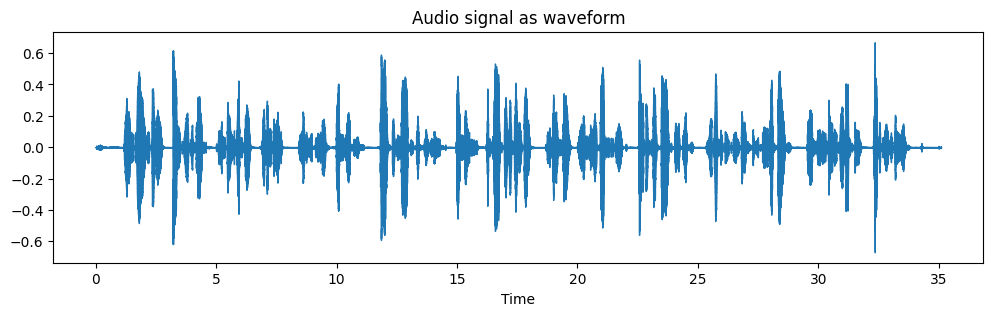

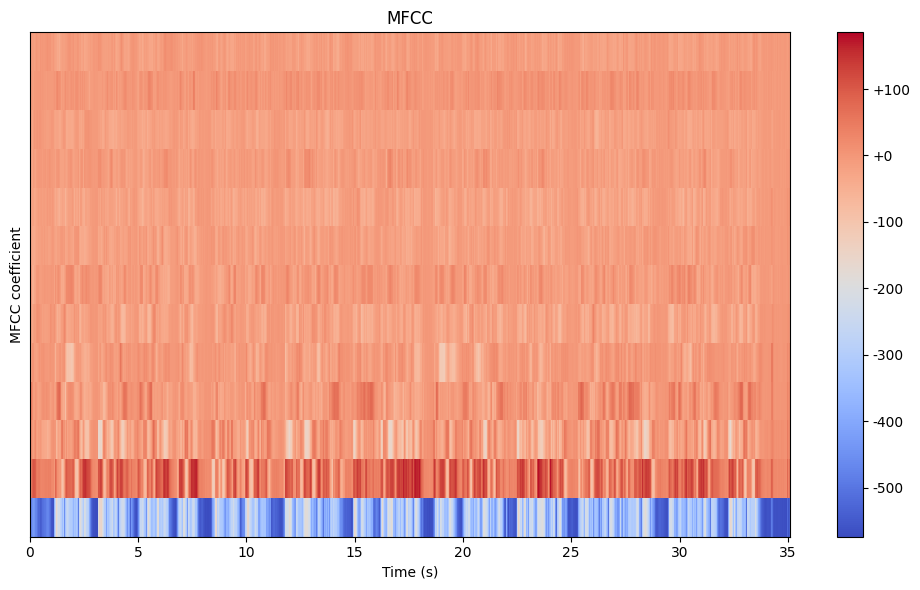

In [13]:
y, sr = librosa.load('audios_development/1.wav')
plt.figure(figsize=(12, 3))
plt.title("Audio signal as waveform")
librosa.display.waveshow(y, sr=sr)

mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
plt.figure(figsize=(10, 6))
librosa.display.specshow(mfcc, x_axis='time', sr=sr, cmap='coolwarm')
plt.colorbar(format='%+2.0f')
plt.title('MFCC')
plt.xlabel('Time (s)')
plt.ylabel('MFCC coefficient')
plt.tight_layout()
plt.show()

Generally, the audio signal’s waveform over time does not provide particularly useful information. Therefore, we opt to analyze each audio from the perspective of its frequency content, focusing on the MFCC.

Since all audio files have different durations, the MFCCs derived from each file will also have varying lengths. However, it is our responsibility to ensure that the same number of features is extracted for every audio file. To achieve this, we can divide each MFCC graph into blocks by imagining a grid overlay and, from each block, extract aggregates such as mean, standard deviation, and maximum. By maintaining a consistent number of blocks for each MFCC, we ensure that the same number of features is extracted for all audio files.

In [14]:
best_N = 0
best_M = 0
best_rmse = 100

for N in range(1, 11):
    for M in range(1, 11):
        t1 = time.time()
        print(f'Developing: N = {N}, M = {M}...')

        df_dev = pd.read_csv("development.csv")
        df_eval = pd.read_csv("evaluation.csv")
        df = pd.concat([df_dev, df_eval], sort=False)
        
        df.loc[df["gender"] == "famale", "gender"] = "female"
        df['tempo'] = df['tempo'].str.replace(r'[^\d.]', '', regex=True).astype(float)
        df = pd.get_dummies(df, columns=["gender", "ethnicity"])

        end_dev = len(df_dev)
        df_dev = df.iloc[:end_dev, :].reset_index(drop=True).drop(columns=['Id'])
        df_eval = df.iloc[end_dev:, :].reset_index(drop=True).drop(columns='age')
        ids_pdf = df_eval['Id'].values
        df_eval = df_eval.drop(columns=['Id'])

        columns_name = [f'mfcc_{stat}_{wr}_{wc}' for wr in range(N-1) for wc in range(M-1) for stat in ['mean', 'std', 'max']]
        columns_name.append('duration')

        data = np.empty((len(dev_files), len(columns_name)))
        for i, file_path in enumerate(dev_files):
            y, sr = librosa.load(f'audios_development/{file_path}')
            duration = len(y) / sr

            mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
            cols_index = np.linspace(0, mfcc.shape[1], M)
            rows_index = np.linspace(0, mfcc.shape[0], N)
            list_statistics = []

            for r in range(len(rows_index)-1):
                for c in range(len(cols_index)-1):
                    window = mfcc[int(rows_index[r]):int(rows_index[r+1]), int(cols_index[c]):int(cols_index[c+1])]
                    list_statistics.extend([np.mean(window), np.std(window), np.max(window)])
            list_statistics.append(duration)

            data[i] = list_statistics

        df_spectr_dev = pd.DataFrame(data, columns=columns_name)
        df_spectr_dev['path'] = dev_files

        df_dev['path'] = dev_files
        df_dev = pd.merge(df_dev, df_spectr_dev, how='inner', on='path')
        df_dev['words_per_second'] = df_dev['num_words'] / df_dev['duration']
        df_dev = df_dev.drop(columns=['path'])

        X = df_dev.drop(columns='age')
        y = df_dev['age'].values

        X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=42, test_size=0.2)

        reg = RandomForestRegressor(n_estimators=300, max_depth=10, random_state=42)
        reg.fit(X_train, y_train)
        y_pred = reg.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)

        if np.sqrt(mse) < best_rmse:
            best_rmse = np.sqrt(mse)
            best_M = M
            best_N = N

        t2 = time.time()
        print(f'r2 -> {r2}')
        print(f'MAE -> {mae}')
        print(f'Sqrt(mse) -> {np.sqrt(mse)}')
        print(f'Execution time: {t2-t1}\n')

Developing: N = 1, M = 1...
r2 -> 0.41867626295903926
MAE -> 6.5176796908625825
Sqrt(mse) -> 9.812740988144403
Execution time: 59.65008902549744

Developing: N = 1, M = 2...
r2 -> 0.41867626295903926
MAE -> 6.5176796908625825
Sqrt(mse) -> 9.812740988144403
Execution time: 55.440993785858154

Developing: N = 1, M = 3...
r2 -> 0.41867626295903926
MAE -> 6.5176796908625825
Sqrt(mse) -> 9.812740988144403
Execution time: 56.09939193725586

Developing: N = 1, M = 4...
r2 -> 0.41867626295903926
MAE -> 6.5176796908625825
Sqrt(mse) -> 9.812740988144403
Execution time: 55.35254788398743

Developing: N = 1, M = 5...
r2 -> 0.41867626295903926
MAE -> 6.5176796908625825
Sqrt(mse) -> 9.812740988144403
Execution time: 55.529707193374634

Developing: N = 1, M = 6...
r2 -> 0.41867626295903926
MAE -> 6.5176796908625825
Sqrt(mse) -> 9.812740988144403
Execution time: 55.59489297866821

Developing: N = 1, M = 7...
r2 -> 0.41867626295903926
MAE -> 6.5176796908625825
Sqrt(mse) -> 9.812740988144403
Execution t

In the cell above, we tested various grid configurations to apply to the MFCC plots of the development audio files. For each grid configuration, we generated a new development dataset containing a different number of MFCC-related features. We then performed a hold-out operation on each dataset and evaluated the regressor's performance using the R² score, Mean Absolute Error, and Root Mean Square Error. It is important to highlight that the Root Mean Square Error was specifically used to determine the optimal grid dimensions, as it is the primary metric for ranking the configurations.

In [15]:
print(f'Best N = {best_N}\nBest M = {best_M}')

Best N = 9
Best M = 2


The result is that the grid yielding the best Root Mean Square Error consists of 18 blocks, characterized by 'best_N' horizontal bands and 'best_M' vertical bands.

With these values, in the following cell, we can finally create the new MFCC-related features and add them to both the development and evaluation dataframes. Additionally, during the feature extraction process, we derive a new feature, 'duration', which indicates the audio file’s length. As we will see later, this feature will be useful for calculating another feature, the speech rate.

In [16]:
N=best_N
M=best_M
columns_name = []
for wr in range(N-1):
  for wc in range(M-1):
    columns_name.append(f'mfcc_mean_{wr},{wc}')
    columns_name.append(f'mfcc_std_{wr},{wc}')
    columns_name.append(f'mfcc_max_{wr},{wc}')
columns_name.append('duration')

data = np.empty((len(dev_files), len(columns_name)))
for i in range(len(dev_files)):
  y, sr = librosa.load('audios_development/'+dev_files[i])
  duration = len(y)/sr
  
  mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
  mfcc_mean = np.mean(mfcc)
  mfcc_std = np.std(mfcc)

  cols_index = np.linspace(0, mfcc.shape[1], M)
  rows_index = np.linspace(0, mfcc.shape[0], N)
  list_statistics = []
  for r in range(len(rows_index)-1):
    for j in range(len(cols_index)-1):
        window = mfcc[round(rows_index[r]):round(rows_index[r+1]), round(cols_index[j]):round(cols_index[j+1])]
        list_statistics.append(np.mean(window))
        list_statistics.append(np.std(window))
        list_statistics.append(np.max(window))
  list_statistics.append(duration)

  data[i] = list_statistics

In [17]:
data_eval = np.empty((len(eval_files), len(columns_name)))
for i in range(len(eval_files)):
  y, sr = librosa.load('audios_evaluation/'+eval_files[i])
  duration = len(y)/sr

  mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
  mfcc_mean = np.mean(mfcc)
  mfcc_std = np.std(mfcc)

  cols_index = np.linspace(0, mfcc.shape[1], M)
  rows_index = np.linspace(0, mfcc.shape[0], N)
  list_statistics = []
  for r in range(len(rows_index)-1):
    for j in range(len(cols_index)-1):
        window = mfcc[round(rows_index[r]):round(rows_index[r+1]), round(cols_index[j]):round(cols_index[j+1])]
        list_statistics.append(np.mean(window))
        list_statistics.append(np.std(window))
        list_statistics.append(np.max(window))
  list_statistics.append(duration)
  data_eval[i] = list_statistics

The newly extracted data are loaded into dedicated dataframes: one for the development dataset and another for the evaluation dataset.

In [18]:
df_spectr_dev = pd.DataFrame(data, columns=columns_name)
df_spectr_eval = pd.DataFrame(data_eval, columns=columns_name)
df_spectr_dev['path'] = dev_files
df_spectr_eval['path'] = eval_files
df_spectr_eval

,"mfcc_mean_0,0","mfcc_std_0,0","mfcc_max_0,0","mfcc_mean_1,0","mfcc_std_1,0","mfcc_max_1,0","mfcc_mean_2,0","mfcc_std_2,0","mfcc_max_2,0","mfcc_mean_3,0",...,"mfcc_std_5,0","mfcc_max_5,0","mfcc_mean_6,0","mfcc_std_6,0","mfcc_max_6,0","mfcc_mean_7,0","mfcc_std_7,0","mfcc_max_7,0",duration,path
0,-123.394791,231.720383,197.990082,9.801272,31.864361,109.370651,25.189861,24.498619,129.664749,9.267679,...,18.074209,45.200535,-1.308443,10.760273,40.086449,4.187037,8.480278,32.391396,38.477143,1.wav
1,-101.012848,200.088120,190.891113,19.465508,30.429495,109.945351,22.786469,26.000959,109.196594,12.485600,...,13.456301,32.174709,-5.809939,12.182775,31.873701,-1.750646,10.300920,37.240631,31.836508,2.wav
2,-75.628632,200.568680,164.952148,-3.253657,36.104877,91.973328,11.437197,17.492300,56.106472,5.504768,...,11.380440,30.540545,-1.935668,12.001466,21.930313,0.393965,10.571820,29.550716,2.405941,3.wav
3,-78.885406,208.006027,217.575912,4.492656,23.948446,74.151077,25.181393,22.750902,114.535973,1.549032,...,11.226042,33.881920,-5.205304,10.909703,25.441944,-5.684588,9.027534,23.711010,31.699229,4.wav
4,-142.919342,237.613571,222.727341,2.618664,30.830269,87.377838,24.923460,26.654533,127.046524,3.619825,...,15.369555,54.161041,-4.902989,13.395326,38.699753,-0.200959,9.137298,33.943214,33.000000,5.wav
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
686,-90.359253,214.932068,208.526901,36.100357,30.868780,121.868271,20.813705,19.365314,87.601387,-0.058782,...,12.174673,36.588749,4.315195,9.928885,27.396425,-2.975844,8.682518,24.854561,2.024490,687.wav
687,-168.364243,229.810883,158.333923,41.410759,24.949419,81.756851,30.053621,20.800547,71.888412,-1.435428,...,18.891550,36.968300,10.157459,13.034013,37.520836,2.863125,14.959226,39.890007,4.947211,688.wav
688,-90.731529,209.039703,230.886795,25.528610,28.495955,107.700378,23.037352,26.264820,118.020401,2.287013,...,13.139992,30.525887,-1.993788,9.956449,32.971775,2.205617,10.231277,33.316368,27.485306,689.wav
689,-68.596786,195.362488,218.957382,-49.735664,23.246342,-4.924557,24.334448,51.717213,145.014496,10.982136,...,16.757353,48.581055,10.279085,9.647735,40.366024,-1.370157,7.912750,20.722580,21.632653,690.wav


In [19]:
df_dev = pd.read_csv("development.csv")
df_eval = pd.read_csv("evaluation.csv")
df = pd.concat([df_dev, df_eval], sort=False)
df.loc[df["gender"] == "famale", "gender"] = "female"
df['tempo'] = df['tempo'].str.replace(r'[^\d.]', '', regex=True).astype(float)
df = pd.get_dummies(df, columns=["gender", "ethnicity"])

df_dev = df.iloc[:end_dev, :].reset_index(drop=True)
df_dev = df_dev.drop(columns=['Id'])
df_dev

,sampling_rate,age,mean_pitch,max_pitch,min_pitch,jitter,shimmer,energy,zcr_mean,spectral_centroid_mean,...,ethnicity_wolof,ethnicity_wu,ethnicity_xasonga,ethnicity_xiang,ethnicity_yakut,ethnicity_yapese,ethnicity_yiddish,ethnicity_yoruba,ethnicity_yupik,ethnicity_zulu
0,22050,24.0,1821.69060,3999.7170,145.43066,0.013795,0.082725,0.002254,0.210093,3112.257251,...,False,False,False,False,False,False,False,False,False,False
1,22050,22.5,1297.81870,3998.8590,145.37268,0.025349,0.096242,0.007819,0.078849,1688.016389,...,False,False,False,False,False,False,False,False,False,False
2,22050,22.0,1332.85240,3998.8025,145.42395,0.019067,0.119456,0.002974,0.105365,2576.901706,...,False,False,False,False,False,False,False,False,False,False
3,22050,22.0,1430.34990,3998.4510,147.98083,0.017004,0.102389,0.022371,0.173701,3269.751413,...,False,False,False,False,False,False,False,False,False,False
4,22050,22.0,1688.72340,3998.6113,145.44772,0.028027,0.124831,0.005369,0.107279,1930.897375,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2928,22050,24.0,1641.14930,3999.1616,145.39359,0.023647,0.115361,0.001879,0.111799,2188.853478,...,False,False,False,False,False,False,False,False,False,False
2929,22050,15.0,1089.60050,3984.6550,145.58409,0.015317,0.126740,0.000339,0.070508,2712.362323,...,False,False,False,False,False,False,False,False,False,False
2930,22050,17.0,994.46484,3989.1785,148.97475,0.009677,0.103535,0.001464,0.058442,2248.698477,...,False,False,False,False,False,False,False,False,False,False
2931,22050,18.0,1600.00820,3999.7559,145.36101,0.019571,0.100946,0.004451,0.115139,1834.596924,...,False,False,False,False,False,False,False,False,False,False


From the cell above, we observe that the development and evaluation dataframes have been loaded and concatenated again. After performing common preprocessing operations, such as one-hot encoding and feature corrections, we can separate them.

In [20]:
df_eval = df.iloc[end_dev:, :].reset_index(drop=True)
df_eval = df_eval.drop(columns='age')
ids_pdf = df_eval['Id'].values
df_eval = df_eval.drop(columns=['Id'])
df_eval

,sampling_rate,mean_pitch,max_pitch,min_pitch,jitter,shimmer,energy,zcr_mean,spectral_centroid_mean,tempo,...,ethnicity_wolof,ethnicity_wu,ethnicity_xasonga,ethnicity_xiang,ethnicity_yakut,ethnicity_yapese,ethnicity_yiddish,ethnicity_yoruba,ethnicity_yupik,ethnicity_zulu
0,22050,1056.91740,3945.1610,145.38750,0.022082,0.171076,0.003136,0.032963,1549.607050,80.749512,...,False,False,False,False,False,False,False,False,False,False
1,22050,1231.84570,3999.1720,145.56432,0.026571,0.132585,0.006783,0.123895,2344.817369,89.102909,...,False,False,False,True,False,False,False,False,False,False
2,22050,958.29065,3445.4490,145.67374,0.018044,0.096289,0.004478,0.089149,1939.574896,123.046875,...,False,False,False,False,False,False,False,False,False,False
3,22050,1396.54170,3998.8948,145.41223,0.027290,0.088901,0.014893,0.097054,1832.059113,123.046875,...,False,False,False,False,False,False,False,False,False,False
4,22050,1633.86770,3999.7632,145.36313,0.021621,0.103855,0.001369,0.140950,2534.611168,112.347147,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
686,22050,570.62740,3900.6730,145.67577,0.018842,0.079197,0.004545,0.072083,1946.502158,112.347147,...,False,False,False,False,False,False,False,False,False,False
687,22050,974.13965,3919.0024,145.90408,0.024367,0.117492,0.000878,0.076900,3319.620800,112.347147,...,False,False,False,False,False,False,False,False,False,False
688,22050,1113.27650,3999.3510,145.38307,0.020637,0.089355,0.009148,0.095613,1973.127197,112.347147,...,False,False,False,False,False,False,False,False,False,False
689,22050,1759.17420,3999.4610,145.56773,0.026118,0.106429,0.003707,0.141474,2137.517812,117.453835,...,False,False,False,False,False,False,False,False,False,False


We proceed to join the two dataframes with their corresponding MFCC feature dataframes. For this operation, we use Pandas' merge function, leveraging the 'path' feature to associate each record in the development and evaluation dataframes with its corresponding record containing MFCC data.

In [21]:
for i in range(len(df_dev)):
  df_dev.loc[i, 'path'] = df_dev.loc[i, 'path'].split('/')[1]
df_dev = pd.merge(df_dev, df_spectr_dev, how='inner', on=None, left_on=None, right_on=None)

for i in range(len(df_eval)):
  df_eval.loc[i, 'path'] = df_eval.loc[i, 'path'].split('/')[1]
df_eval = pd.merge(df_eval, df_spectr_eval, how='inner', on=None, left_on=None, right_on=None)

We now calculate the speech rate for each audio file. This could be useful for the regressor, as it might help identify a trend where individuals speaking at a slower rate tend to be older, and vice versa.

In [22]:
df_dev['words_per_second'] = 0
for i in range(len(df_dev)):
  df_dev.loc[i, 'words_per_second'] = df_dev.loc[i, 'num_words']/df_dev.loc[i, 'duration']

df_eval['words_per_second'] = 0
for i in range(len(df_eval)):
  df_eval.loc[i, 'words_per_second'] = df_eval.loc[i, 'num_words']/df_eval.loc[i, 'duration']

/var/folders/gn/gprl214x7j3gwnw0v_gdqq480000gn/T/ipykernel_31117/1876583265.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.966078697421981' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_dev.loc[i, 'words_per_second'] = df_dev.loc[i, 'num_words']/df_dev.loc[i, 'duration']
/var/folders/gn/gprl214x7j3gwnw0v_gdqq480000gn/T/ipykernel_31117/1876583265.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.7932724437513923' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_eval.loc[i, 'words_per_second'] = df_eval.loc[i, 'num_words']/df_eval.loc[i, 'duration']


In [23]:
df_dev = df_dev.drop(columns=['path'])
df_eval = df_eval.drop(columns=['path'])

After calculating and adding the new features, we verify if the metrics have improved.

Using the development dataframe, we apply the train_test_split function and train a Random Forest Regressor with randomly chosen hyperparameters.

In [24]:
X = df_dev.drop(columns='age')
y = df_dev['age'].values
feature_names = X.columns
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=42, test_size = 0.2)
reg = RandomForestRegressor(300, max_depth=10, random_state=42)
reg.fit(X_train , y_train)
y_pred = reg.predict(X_test)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f'r2 -> {r2}')
print(f'MAE -> {mae}')
print(f'Sqrt(mse) -> {np.sqrt(mse)}')

r2 -> 0.458624937187619
MAE -> 6.425841317227425
Sqrt(mse) -> 9.469573751153517


Significant improvements are observed: the R² score has increased compared to the default Random Forest Regressor, while the RMSE has decreased.

In [25]:
sorted(zip(feature_names, reg.feature_importances_), key=lambda x: x[1], reverse=True)

[('duration', np.float64(0.28760786021656143)),
 ('silence_duration', np.float64(0.05479746351406243)),
 ('ethnicity_english', np.float64(0.049042601895067275)),
 ('words_per_second', np.float64(0.03360035746369251)),
 ('mfcc_max_1,0', np.float64(0.02860937706238995)),
 ('jitter', np.float64(0.0277532811261021)),
 ('mfcc_std_4,0', np.float64(0.023882459584175033)),
 ('spectral_centroid_mean', np.float64(0.020513441695226464)),
 ('mfcc_mean_4,0', np.float64(0.019966954335626706)),
 ('mfcc_mean_5,0', np.float64(0.01945863449074218)),
 ('mfcc_std_2,0', np.float64(0.018912870508580547)),
 ('min_pitch', np.float64(0.018458429484037482)),
 ('shimmer', np.float64(0.01814273466012622)),
 ('energy', np.float64(0.017563637547637685)),
 ('mfcc_max_4,0', np.float64(0.01705521145689471)),
 ('hnr', np.float64(0.016158981344916064)),
 ('mfcc_std_3,0', np.float64(0.015981092367520915)),
 ('mfcc_max_6,0', np.float64(0.015754417476433594)),
 ('mfcc_mean_1,0', np.float64(0.015244621282114694)),
 ('mfcc_s

We also notice a substantial change in feature importance, with many of the newly added features ranking among the most influential.

Returning to the discussion on 'gender', we attempt to address this issue by creating two separate regressors with the same hyperparameters as the previous regressor: one for males and one for females. These regressors are trained using the corresponding records in the development dataframe.

In [26]:
X_male = df_dev.loc[df_dev["gender_male"] == True].drop(columns='age')
y_male = df_dev.loc[df_dev["gender_male"] == True]['age'].values
X_female = df_dev.loc[df_dev["gender_female"] == True].drop(columns='age')
y_female = df_dev.loc[df_dev["gender_female"] == True]['age'].values
feature_names = X_male.columns

X_train_male, X_test_male, y_train_male, y_test_male = train_test_split(X_male, y_male, shuffle=True, random_state=42)
X_train_female, X_test_female, y_train_female, y_test_female = train_test_split(X_female, y_female, shuffle=True, random_state=42)

reg_male = RandomForestRegressor(n_estimators=300, max_depth=10, random_state=42)
reg_male.fit(X_train_male , y_train_male)
y_pred_male = reg_male.predict(X_test_male)
r2 = r2_score(y_test_male, y_pred_male)
mae = mean_absolute_error(y_test_male, y_pred_male)
mse = mean_squared_error(y_test_male, y_pred_male)
print("Male:")
print(f'r2 -> {r2}')
print(f'MAE -> {mae}')
print(f'Sqrt(mse) -> {np.sqrt(mse)}\n')

reg_female = RandomForestRegressor(n_estimators=300, max_depth=10, random_state=42)
reg_female.fit(X_train_female , y_train_female)
y_pred_female = reg_female.predict(X_test_female)
r2 = r2_score(y_test_female, y_pred_female)
mae = mean_absolute_error(y_test_female, y_pred_female)
mse = mean_squared_error(y_test_female, y_pred_female)
print("Female:")
print(f'r2 -> {r2}')
print(f'MAE -> {mae}')
print(f'Sqrt(mse) -> {np.sqrt(mse)}\n')

y_pred = np.concatenate([y_pred_male, y_pred_female])
y_true = np.concatenate([y_test_male, y_test_female])

r2 = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
print(f'General metrics:')
print(f'r2 -> {r2}')
print(f'MAE -> {mae}')
print(f'Sqrt(mse) -> {np.sqrt(mse)}')

Male:
r2 -> 0.3534311747837656
MAE -> 6.816227636245203
Sqrt(mse) -> 9.377865966133726

Female:
r2 -> 0.41132330296056274
MAE -> 7.113424550308308
Sqrt(mse) -> 10.304807244958653

General metrics:
r2 -> 0.38647627947846874
MAE -> 6.9648260932767565
Sqrt(mse) -> 9.852243968622618


In initial tests, the metrics were not very satisfactory. To improve results, we applied a grid search to both regressors to determine the optimal configuration for each.

In [29]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30]
}
rf_male = RandomForestRegressor( random_state=42)
grid_search_m = GridSearchCV(estimator=rf_male, param_grid=param_grid, cv=5, scoring=root_mean_squared_error)

grid_search_m.fit(X_male, y_male)
best_rf_m = grid_search_m.best_estimator_


rf_female = RandomForestRegressor( random_state=42)
grid_search_f = GridSearchCV(estimator=rf_female, param_grid=param_grid, cv=5, scoring=root_mean_squared_error)

grid_search_f.fit(X_female, y_female)
best_rf_f = grid_search_f.best_estimator_

/Users/andrealanzillotta/Data Science Lab/DataScienceLab/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/andrealanzillotta/Data Science Lab/DataScienceLab/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/andrealanzillotta/Data Science Lab/DataScienceLab/lib/python3.12/site-packages/sklearn/utils/_param_validation.py", line 191, in wrapper
    params = func_sig.bind(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/inspect.py", line 3273, in bind
    return self._bind(args, kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/

In [37]:
best_rf_m

RandomForestRegressor(max_depth=10, random_state=42)

In [38]:
best_rf_m.n_estimators

100

In [31]:
best_rf_f

RandomForestRegressor(max_depth=10, random_state=42)

In [39]:
best_rf_f.n_estimators

100

Finally, after separating the 'male' and 'female' records in the evaluation dataframe, we apply the predict method of each regressor to obtain the results. These results are then saved to the 'output.csv' file.

In [32]:
df_eval['Id'] = ids_pdf
X_male_eval = df_eval.loc[df_eval["gender_male"] == True]
ids_male = df_eval.loc[df_eval["gender_male"] == True, 'Id']
X_female_eval = df_eval.loc[df_eval["gender_female"] == True]
ids_female = df_eval.loc[df_eval["gender_female"] == True, 'Id']
X_male_eval = X_male_eval.drop(columns=['Id'])
X_female_eval = X_female_eval.drop(columns=['Id'])

In [33]:
predictions = np.zeros((len(ids_pdf), 2))
reg_male.fit(X_male, y_male)
reg_female.fit(X_female, y_female)
y_male_pred = reg_male.predict(X_male_eval)
y_female_pred = reg_female.predict(X_female_eval)

In [34]:
predictions[0:len(y_male_pred), 0] = ids_male
predictions[0:len(y_male_pred), 1] = y_male_pred
predictions[len(y_male_pred):, 0] = ids_female
predictions[len(y_male_pred):, 1] = y_female_pred
sorted_predictions = predictions[np.argsort(predictions[:, 0])]

In [35]:
pd.DataFrame(sorted_predictions[:, 1], index=[int(el) for el in sorted_predictions[:,0]]).to_csv("output.csv", index_label="Id", header=["Predicted"])